Import lib

In [27]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Konfig

In [28]:
SYMBOL = 'BNBUSDT'
INTERVAL = '1d'
LIMIT = 1000

print(f"Konfigurasi:")
print(f"Symbol: {SYMBOL}")
print(f"Interval: {INTERVAL}")
print(f"Limit: {LIMIT} data")

Konfigurasi:
Symbol: BNBUSDT
Interval: 1d
Limit: 1000 data


Fetch Data Historis

In [29]:
def fetch_historical_data(symbol=SYMBOL, interval=INTERVAL, limit=LIMIT):
    """Mengambil data historis dari Binance API"""
    print("Mengambil data historis dari Binance API...")
    
    url = "https://api.binance.com/api/v3/klines"
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }
    
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        df = pd.DataFrame(data, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_volume', 'trades', 'taker_buy_base',
            'taker_buy_quote', 'ignore'
        ])
        
        df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['open'] = df['open'].astype(float)
        df['high'] = df['high'].astype(float)
        df['low'] = df['low'].astype(float)
        df['close'] = df['close'].astype(float)
        df['volume'] = df['volume'].astype(float)
        
        print(f"Berhasil mengambil {len(df)} data historis")
        return df
        
    except Exception as e:
        print(f"Gagal mengambil data dari API: {e}")

print("Fungsi fetch data siap digunakan!")


Fungsi fetch data siap digunakan!


Ambil Data Historis

In [30]:
df = fetch_historical_data()
print(f"\nPreview data:")
print(df.head())
print(f"\nInfo data:")
print(df.info())

Mengambil data historis dari Binance API...
Berhasil mengambil 1000 data historis

Preview data:
   timestamp   open   high    low  close       volume
0 2023-02-10  306.2  309.2  302.5  305.8   295784.976
1 2023-02-11  305.9  311.4  305.1  310.4   154488.761
2 2023-02-12  310.5  321.0  306.0  312.6   291500.270
3 2023-02-13  312.6  315.7  282.8  294.3  1065985.594
4 2023-02-14  294.3  301.7  289.8  296.2   494698.654

Info data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1000 non-null   datetime64[ns]
 1   open       1000 non-null   float64       
 2   high       1000 non-null   float64       
 3   low        1000 non-null   float64       
 4   close      1000 non-null   float64       
 5   volume     1000 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 47.0 KB
None


Nilai Korelasi

In [31]:
corr = df[['open', 'high', 'low', 'close', 'volume']].corr()
print(corr)

            open      high       low     close    volume
open    1.000000  0.998511  0.996736  0.997026 -0.141685
high    0.998511  1.000000  0.996204  0.998733 -0.120538
low     0.996736  0.996204  1.000000  0.997875 -0.171504
close   0.997026  0.998733  0.997875  1.000000 -0.141280
volume -0.141685 -0.120538 -0.171504 -0.141280  1.000000


Validasi dan Cleaning Data

In [32]:
def validate_data(df):
    """Validasi dan membersihkan data"""
    print("Memvalidasi dan membersihkan data...")
    df = df.dropna()
    
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    df = df[
        (df['high'] >= df['low']) &
        (df['high'] >= df['open']) &
        (df['high'] >= df['close']) &
        (df['low'] <= df['open']) &
        (df['low'] <= df['close']) &
        (df['close'] > 0) &
        (df['volume'] >= 0)
    ]
    
    print(f"Data valid: {len(df)} baris")
    return df

df = validate_data(df)


Memvalidasi dan membersihkan data...
Data valid: 1000 baris


Exploratory Data Analysis (EDA)

Statistik Deskriptif:
              open         high          low        close        volume
count  1000.000000  1000.000000  1000.000000  1000.000000  1.000000e+03
mean    515.685630   526.763900   504.157730   516.315420  4.694819e+05
std     229.860844   236.635684   222.940946   230.181275  4.097287e+05
min     205.100000   207.100000   202.000000   205.100000  5.164829e+04
25%     306.125000   310.750000   300.850000   306.225000  2.106689e+05
50%     570.300000   582.700000   555.350000   570.450000  3.343402e+05
75%     647.560000   659.047500   635.330000   647.885000  5.803124e+05
max    1307.400000  1375.110000  1264.320000  1307.400000  4.050393e+06


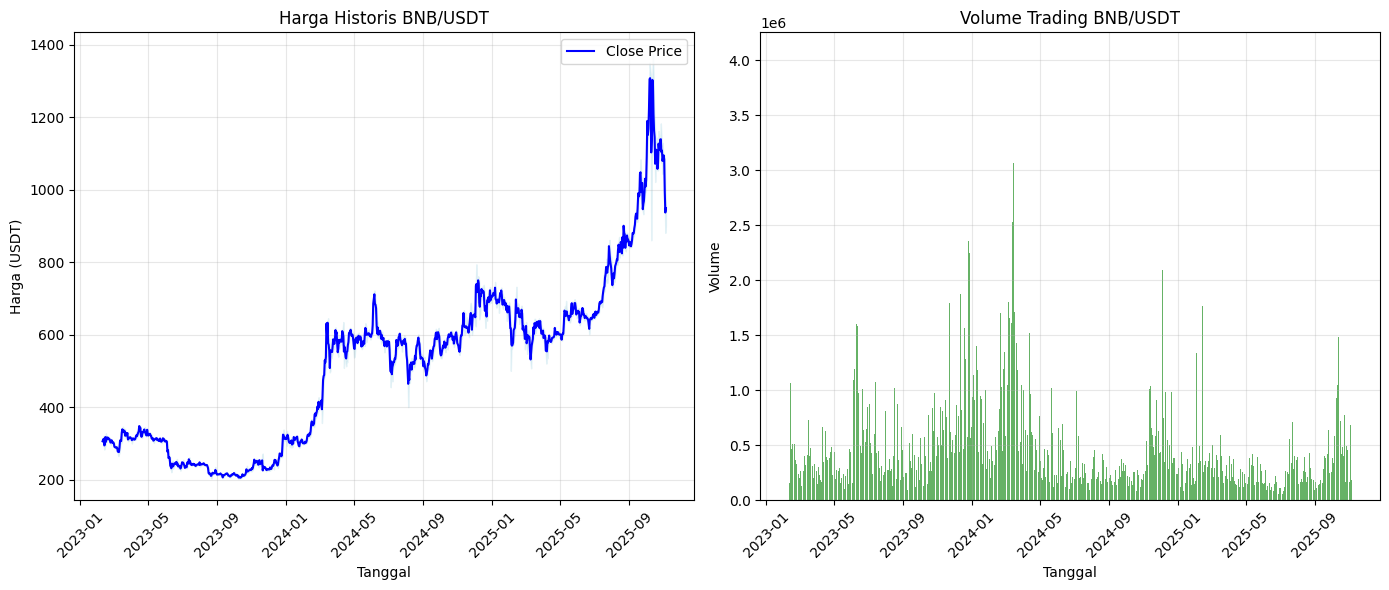

In [33]:
print("Statistik Deskriptif:")
print(df[['open', 'high', 'low', 'close', 'volume']].describe())

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df['timestamp'], df['close'], label='Close Price', color='blue', linewidth=1.5)
plt.fill_between(df['timestamp'], df['low'], df['high'], alpha=0.3, color='lightblue')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USDT)')
plt.title('Harga Historis BNB/USDT')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(df['timestamp'], df['volume'], alpha=0.6, color='green')
plt.xlabel('Tanggal')
plt.ylabel('Volume')
plt.title('Volume Trading BNB/USDT')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Persiapan Data untuk Training

In [34]:
df['next_close'] = df['close'].shift(-1)

df_train = df[:-1].copy()

X = df_train[['close', 'open', 'high', 'low', 'volume']].values
y = df_train['next_close'].values

print(f"Data training siap!")
print(f"Jumlah samples: {len(X)}")
print(f"Jumlah features: {X.shape[1]}")


Data training siap!
Jumlah samples: 999
Jumlah features: 5


Split Data Training & Testing

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Data berhasil di-split!")
print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")

Data berhasil di-split!
Training set: 799 samples
Testing set: 200 samples


Training Model

In [36]:
model = LinearRegression()
model.fit(X_train, y_train)

print("Model berhasil dilatih!")
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_:.2f}")

Model berhasil dilatih!
Coefficients: [ 9.11489926e-01  3.86406701e-03 -1.12354767e-02  9.68337286e-02
  2.55844450e-06]
Intercept: -0.26


Evaluasi Model

In [37]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Evaluasi Model:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Evaluasi Model:
Mean Squared Error (MSE): 849.45
Root Mean Squared Error (RMSE): 29.15
Mean Absolute Error (MAE): 17.44
Mean Absolute Percentage Error (MAPE): 1.93%


Visualisasi Hasil Prediksi

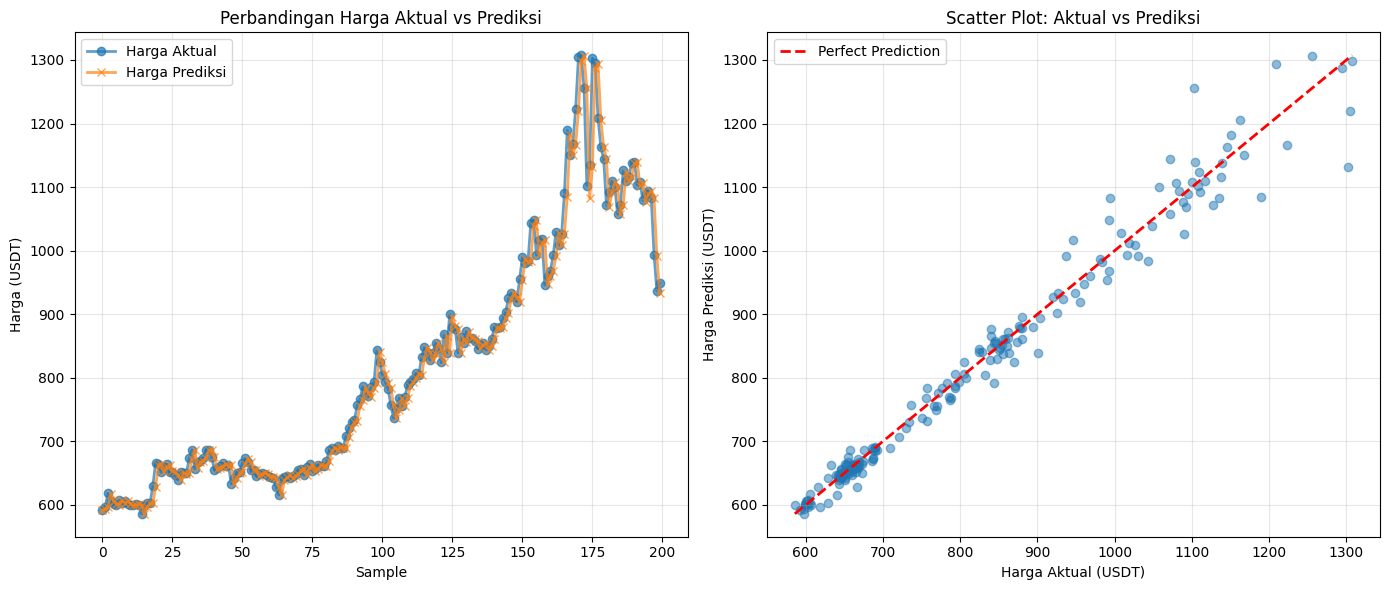

In [38]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_test, label='Harga Aktual', marker='o', alpha=0.7, linewidth=2)
plt.plot(y_pred, label='Harga Prediksi', marker='x', alpha=0.7, linewidth=2)
plt.xlabel('Sample')
plt.ylabel('Harga (USDT)')
plt.title('Perbandingan Harga Aktual vs Prediksi')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Harga Aktual (USDT)')
plt.ylabel('Harga Prediksi (USDT)')
plt.title('Scatter Plot: Aktual vs Prediksi')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Fetch Harga Real-time

In [39]:
def fetch_real_time_data(symbol=SYMBOL):
    """Mengambil harga real-time dari Binance"""
    print("Mengambil harga real-time...")
    
    url = "https://api.binance.com/api/v3/ticker/price"
    params = {'symbol': symbol}
    
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        price = float(data['price'])
        print(f"Harga real-time: {price:.2f} USDT")
        return price
        
    except Exception as e:
        print(f"Gagal mengambil harga real-time: {e}")
        fallback_price = df['close'].iloc[-1]
        print(f"Menggunakan harga terakhir: {fallback_price:.2f} USDT")
        return fallback_price

print("Fungsi fetch real-time siap!")


Fungsi fetch real-time siap!


Prediksi Harga Berikutnya

In [40]:
current_price = fetch_real_time_data()

last_row = df.iloc[-1]

features = np.array([[
    current_price,
    last_row['open'],
    last_row['high'],
    last_row['low'],
    last_row['volume']
]])

predicted_price = model.predict(features)[0]

change_pct = ((predicted_price - current_price) / current_price) * 100
direction = "Naik" if change_pct > 0 else "Turun"

print(f"\n{'='*60}")
print("HASIL PREDIKSI")
print(f"{'='*60}")
print(f"Harga saat ini: {current_price:.2f} USDT")
print(f"Prediksi harga berikutnya: {predicted_price:.2f} USDT")
print(f"{direction} {abs(change_pct):.2f}%")
print(f"{'='*60}")


Mengambil harga real-time...
Harga real-time: 949.34 USDT

HASIL PREDIKSI
Harga saat ini: 949.34 USDT
Prediksi harga berikutnya: 945.60 USDT
Turun 0.39%


Visualisasi Prediksi

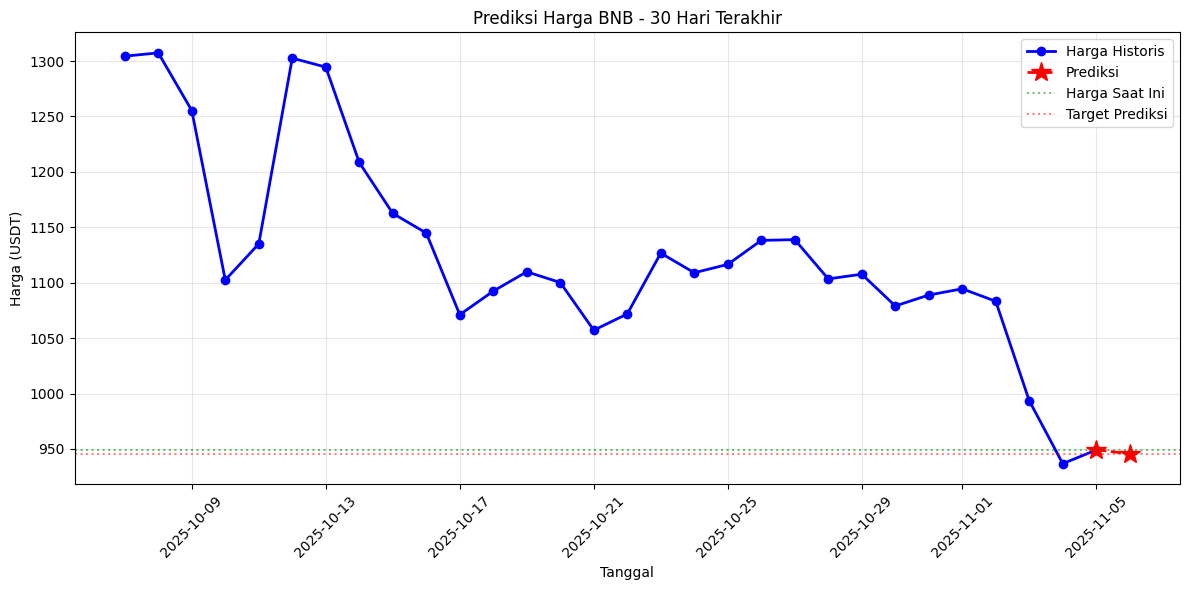

In [41]:
recent_df = df.tail(30).copy()

plt.figure(figsize=(12, 6))
plt.plot(recent_df['timestamp'], recent_df['close'], 
         marker='o', label='Harga Historis', linewidth=2, color='blue')

next_date = recent_df['timestamp'].iloc[-1] + timedelta(days=1)
plt.plot([recent_df['timestamp'].iloc[-1], next_date], 
         [current_price, predicted_price],
         marker='*', markersize=15, linestyle='--', 
         linewidth=2, color='red', label='Prediksi')

plt.axhline(y=current_price, color='green', linestyle=':', alpha=0.5, label='Harga Saat Ini')
plt.axhline(y=predicted_price, color='red', linestyle=':', alpha=0.5, label='Target Prediksi')

plt.xlabel('Tanggal')
plt.ylabel('Harga (USDT)')
plt.title('Prediksi Harga BNB - 30 Hari Terakhir')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
print("\n" + "="*60)
print("RINGKASAN LENGKAP")
print("="*60)
print(f"Dataset:")
print(f"  - Total data: {len(df)} hari")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Testing samples: {len(X_test)}")
print(f"\nPerforma Model:")
print(f"  - MSE: {mse:.2f}")
print(f"  - RMSE: {rmse:.2f}")
print(f"  - MAE: {mae:.2f}")
print(f"  - MAPE: {mape:.2f}%")
print(f"\nPrediksi:")
print(f"  - Harga saat ini: {current_price:.2f} USDT")
print(f"  - Prediksi harga: {predicted_price:.2f} USDT")
print(f"  - Perubahan: {direction} {abs(change_pct):.2f}%")
print("="*60)


RINGKASAN LENGKAP
Dataset:
  - Total data: 1000 hari
  - Training samples: 799
  - Testing samples: 200

Performa Model:
  - MSE: 849.45
  - RMSE: 29.15
  - MAE: 17.44
  - MAPE: 1.93%

Prediksi:
  - Harga saat ini: 949.34 USDT
  - Prediksi harga: 945.60 USDT
  - Perubahan: Turun 0.39%
